## Glossary

- Cost: The imperfection of assigning one thing to another, eg. player to role, team_shape to template, etc. The smaller the value, the better quality of the assignment.
- Formation: A grouping of shapes, eg. the 4-4-2 formation is the grouping of various shapes such as the vanilla 4-4-2, 4-4 diamond-2, 4-2-2-2, etc.
- Observed: Shapes and roles that we are calculating from the tracking data of a game
- Role: An individual role, such as LB. Players are associated with roles for a period of time.
- Sequence: The model consumes aggregated data over a set of frames aka over a sequence. The aggregation is user defined but it's typically the mean coordinates over a second.
- Shape: A set of co-occuring outfield roles for the team
- Template: Some pre-defined shapes and corresponding roles that we have specified in a manner such that most observed shapes are similar to at least one of the templates

## Output structure

We run the shape models for rolling windows of 5 minutes over a match. For a game with no added time we would have 82 sets of outputs with the first window spanning minutes 0 to 5 of the first half, and the last window spanning minutes 85 to 90 of the second half. Each run of the model has four sets of outputs, one for each combination of ( team, each team in possession. )

However, there are cases where we may not able to get outputs, for eg. if there was a substition during the window which does not leave us with enough data available to calculate shapes so we may not necessarily have all 82 windows with 4 sets of outputs each time.

For each of the 4 X 82 outputs, we have team level and role level information. This information should become clearer through the tutorial.

## Setup

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pandas as pd
import numpy as np
import os
import logging
import sys
import json

log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc, Ellipse

#### Required functions

Below we introcude a function that plots a football pitch that is designed for plotting our data.

In [3]:
def draw_pitch(
  ax, 
  color='black', 
  lw=1
):
   """
   Matplotlib implementation of a pitch
   Parameters
   ---------
   ax: axes object
   (default: ``matplotlib.pyplot.gca()``) A matplotlib axes object
   color: str
   (default: 'black') Colour of the drawn pitch
   lw: int
   (default: 1) Linewidth of the plotted lines
   Returns
   ---------
   axes object
     A matplotlib axes object containing the pitch lines
   Example
   ---------
   To plot this pitch, include the following commands in your notebook.
   Note: they have to be in this order to plot!
   >>> plt.figure(figsize=(12*1.05,12*0.68),frameon=False)
   >>> opta.draw_pitch()
   >>> plt.xlim(-10,110)
   >>> plt.ylim(-10,110)
   >>> plt.show()
   Then add your mapping on top (e.g. plt.scatter)
   """

   LINE_WD = lw
   PITCH_MIN_X = -52.5
   PITCH_MAX_X = 52.5
   PITCH_MIN_Y = -34
   PITCH_MAX_Y = 34

   # Sidelines
   ax.plot([PITCH_MIN_X, PITCH_MIN_X], [PITCH_MIN_Y, PITCH_MAX_Y], color, lw=LINE_WD)
   ax.plot([PITCH_MAX_X, PITCH_MAX_X], [PITCH_MIN_Y, PITCH_MAX_Y], color, lw=LINE_WD)
   ax.plot([PITCH_MIN_X, PITCH_MAX_X], [PITCH_MIN_Y, PITCH_MIN_Y], color, lw=LINE_WD)
   ax.plot([PITCH_MIN_X, PITCH_MAX_X], [PITCH_MAX_Y, PITCH_MAX_Y], color, lw=LINE_WD)

   # half way line
   ax.plot([0, 0], [PITCH_MIN_Y, PITCH_MAX_Y], color, lw=LINE_WD)

   # Penalty areas
   ax.plot([PITCH_MIN_X, PITCH_MIN_X + 16.15], [-20.15, -20.15], color, lw=LINE_WD)
   ax.plot([PITCH_MIN_X, PITCH_MIN_X + 16.15], [20.15, 20.15], color, lw=LINE_WD)
   ax.plot([PITCH_MIN_X + 16.15, PITCH_MIN_X + 16.15], [-20.15, 20.15], color, lw=LINE_WD)
   ax.plot([PITCH_MAX_X, PITCH_MAX_X - 16.15], [-20.15, -20.15], color, lw=LINE_WD)
   ax.plot([PITCH_MAX_X, PITCH_MAX_X - 16.15], [20.15, 20.15], color, lw=LINE_WD)
   ax.plot([PITCH_MAX_X - 16.15, PITCH_MAX_X - 16.15], [-20.15, 20.15], color, lw=LINE_WD)

   # Goal areas
   ax.plot([PITCH_MIN_X, PITCH_MIN_X + 5.50], [9.16, 9.16], color, lw=LINE_WD)
   ax.plot([PITCH_MIN_X, PITCH_MIN_X + 5.50], [-9.16, -9.16], color, lw=LINE_WD)
   ax.plot([PITCH_MIN_X + 5.50, PITCH_MIN_X + 5.50], [-9.16, 9.16], color, lw=LINE_WD)

   ax.plot([PITCH_MAX_X, PITCH_MAX_X - 5.50], [9.16, 9.16], color, lw=LINE_WD)
   ax.plot([PITCH_MAX_X, PITCH_MAX_X - 5.50], [-9.16, -9.16], color, lw=LINE_WD)
   ax.plot([PITCH_MAX_X - 5.50, PITCH_MAX_X - 5.50], [-9.16, 9.16], color, lw=LINE_WD)

   # Penalty spot
   ax.add_artist(Circle((PITCH_MIN_X + 11, 0), .5, color=color, lw=LINE_WD))
   ax.add_artist(Circle((PITCH_MAX_X - 11, 0), .5, color=color, lw=LINE_WD))

   # Goals
   ax.plot([PITCH_MAX_X, PITCH_MAX_X], [3.66, -3.66], color, lw=4)
   ax.plot([PITCH_MIN_X, PITCH_MIN_X], [3.66, -3.66], color, lw=4)

   # Centre circle
   ax.add_artist(Circle((0, 0), 9.15, color=color, fill=False, lw=LINE_WD))
   ax.add_artist(Circle((0, 0), .5, color=color, lw=LINE_WD))

   ##### new
   ax.add_artist(Arc((PITCH_MIN_X + 11, 0),
                 width=9.15 * 2, height=9.15 * 2, theta1=-55, theta2=55, linewidth=LINE_WD,
                 color=color, fill=False))
   ax.add_artist(Arc((PITCH_MAX_X - 11, 0),
                 width=9.15 * 2, height=9.15 * 2, theta1=124, theta2=236, linewidth=LINE_WD,
                 color=color, fill=False))

   ax.add_artist(Arc((PITCH_MIN_X, PITCH_MAX_Y),
                 width=2, height=2, theta1=-90, theta2=0,
                 linewidth=LINE_WD, color=color, fill=False))
   ax.add_artist(Arc((PITCH_MAX_X, PITCH_MAX_Y),
                 width=2, height=2, theta1=180, theta2=270,
                 linewidth=LINE_WD, color=color, fill=False))
   ax.add_artist(Arc((PITCH_MIN_X, PITCH_MIN_Y),
                 width=2, height=2, theta1=0, theta2=90,
                 linewidth=LINE_WD, color=color, fill=False))
   ax.add_artist(Arc((PITCH_MAX_X, PITCH_MIN_Y),
                 width=2, height=2, theta1=90, theta2=180,
                 linewidth=LINE_WD, color=color, fill=False))

## Model Outputs

Please use the game wit the game_id 1 for this tutorial.
Later parts of the tutorial refer to some specific players and teams of this game.
It will very likely not work with another game.

In [4]:
# specify the location of the local copies of the shape outputs

current_directory = os.getcwd()
base_path = os.path.join(os.path.join(os.path.dirname(current_directory),"data"),'first_10_shapes')

filename = os.path.join(base_path,'1.json')
print(filename)

#filename = '{path to shape data}/1.json'


c:\Users\Gabriel\OneDrive\Escritorio\SportsAnalyticsCourse\OptaForum\OptaChallenge_Clustering_Player_Styles\data\first_10_shapes\1.json


In [5]:
# helper functions

def transform_x_from_opta_to_real_world(x):
    return ( x - 50 ) * 105 / 100
    
def transform_y_from_opta_to_real_world(y):
    return ( y - 50 ) * 68 / 100
    
def get_s_from_mmss(x: str):
    
    mm_ss = x.split(':')
    s = float(mm_ss[0]) * 60
    s = s + float(mm_ss[1])

    return s

def get_team_id(which_team, teams):

    return [i+1 for i in range(len(teams)) if teams[i] == which_team][0]

In [6]:
# the shape outputs

with open(
    os.path.join(filename), 
    'r'
) as handle:
    shape_outputs = json.load(handle)


In [7]:
# compiling the data from the feed entries

df_shape_team = [pd.DataFrame() for x in enumerate(shape_outputs['liveData']['shapes'])]
df_shape_player = [pd.DataFrame() for x in enumerate(shape_outputs['liveData']['shapes'])]

for shape_index, shape_output in enumerate(shape_outputs['liveData']['shapes']):
    
    # if shape_index > 1:
    #     continue

    for shape_contestant_index, shape_contestant_output in enumerate(shape_output['contestant']):

        for possession in ['inPossession','outOfPossession']:

            # try catch because it's possible that one of the outputs isn't populated 
            try:

                df_shape_team_increment = pd.DataFrame({
                    'team_id':[shape_contestant_index + 1],
                    'team_uuid':[shape_contestant_output['id']],
                    'period':[shape_output['periodId']]
                })
                
                df_shape_team_increment['possession'] = possession
                period_start = get_s_from_mmss(shape_contestant_output[possession]['shape'][0]['periodStart'])
                period_end = get_s_from_mmss(shape_contestant_output[possession]['shape'][0]['periodEnd'])
                
                df_shape_team_increment['period_start'] = period_start
                df_shape_team_increment['period_end'] = period_end

                # this info won't be available if the team had less than 
                # 10 outfield players on the pitch, eg. on a red card.
                # You will still have a placeholder from the above lines
                
                df_shape_team_increment['team_shape_template_id'] = shape_contestant_output[possession]['shape'][0]['labelId']
                df_shape_team_increment['team_shape'] = shape_contestant_output[possession]['shape'][0]['label']
                df_shape_team_increment['formation'] = shape_contestant_output[possession]['shape'][0]['formation']
                df_shape_team_increment['shape_assignment_cost'] = shape_contestant_output[possession]['shape'][0]['fitScore']

            except Exception as e:

                if 'period_end' not in df_shape_team_increment.columns:
                    df_shape_team_increment = pd.DataFrame()
            
            df_shape_team[shape_index] = df_shape_team[shape_index] \
                .append(df_shape_team_increment)
            
            df_shape_player_increment = pd.DataFrame()
            
            try:

                df_shape_player_increment = pd.DataFrame(
                    shape_contestant_output[possession]['shape'][0]['shapeRole']['role']
                )
                df_shape_player_increment.rename(
                    columns = {
                        'id':'role_id',
                        'playerId':'player_uuid',
                        'shirtNumber':'jersey_no',
                        'averageRolePositionX':'mean_x',
                        'averageRolePositionY':'mean_y',
                        # below available only if 10 outfield player
                        'fitScore':'role_assignment_cost',
                        'roleDescription':'role_description'
                    },
                    inplace = True
                )
                df_shape_player_increment['possession'] = possession
                df_shape_player_increment['team_id'] = shape_contestant_index + 1
                df_shape_player_increment['team_uuid'] = shape_contestant_output['id']
                df_shape_player_increment['possession'] = possession
                df_shape_player_increment['period'] = shape_output['periodId']
                df_shape_player_increment['period_start'] = period_start
                df_shape_player_increment['period_end'] = period_end

            except Exception as e:

                pass
            
            df_shape_player[shape_index] = df_shape_player[shape_index] \
                .append(df_shape_player_increment)
            

df_shape_team = pd.concat(df_shape_team)

df_shape_player = pd.concat(df_shape_player)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_816\159712297.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_shape_team[shape_index] = df_shape_team[shape_index] \
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_816\159712297.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_shape_player[shape_index] = df_shape_player[shape_index] \
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_816\159712297.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_shape_team[shape_index] = df_shape_team[shape_index] \
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_816\159712297.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_shape_playe

In [9]:
# the role names are mixed up for one of the shape templates so correcting that

df_correction = df_shape_team[
    df_shape_team['team_shape_template_id'] == '0_17'
][
    ['team_id','possession','period','period_start']
]

df_correction['needs_correction'] = True

df_shape_player = df_correction.merge(
    df_shape_player,
    on = ['team_id','possession','period','period_start'],
    how = 'right'
)

df_shape_player[
    ( -df_shape_player['needs_correction'].isnull() ) 
    # ( df_shape_player['role_description'] == 'WB.R'
]

df_shape_player.loc[
    ( -df_shape_player['needs_correction'].isnull() ) & \
    ( df_shape_player['role_description'] == 'WB.R' ),
    'role_description'
] = 'CB.R'
df_shape_player.loc[
    ( -df_shape_player['needs_correction'].isnull() ) & \
    ( df_shape_player['role_description'] == 'WB.L' ),
    'role_description'
] = 'FB.L'

del df_shape_player['needs_correction']

In [10]:
# fixing data types, some basic preprocessing on the data

df_shape_team = df_shape_team.astype({
    'period':int,
    'shape_assignment_cost':float
})

df_shape_team['possession'] = df_shape_team['possession'].map(
    {'inPossession':int(1),'outOfPossession':int(0)}
)

def get_role_id(x):
    return int(x.split(' ')[1])
    
df_shape_player['role_id'] = df_shape_player['role_id'].apply(get_role_id)
df_shape_player['possession'] = df_shape_player['possession'].map(
    {'inPossession':int(1),'outOfPossession':int(0)}
)

df_shape_player = df_shape_player.astype({
    'period':int,
    'jersey_no':int,
    'mean_x':float,
    'mean_y':float,
    'role_assignment_cost':float
})


In [11]:
# assigning a unique value to each shape occurrence for easier cross-referencing later
# there can be multiple templates for the same team_shape though. Ignoring that for now

def get_indexes(
    df_shape_team,
    by_template = False
):

    df_team_poss_formn_shape_index = pd.DataFrame(
        df_shape_team[
            ['team_id','possession','formation','team_shape'] + \
            (['team_shape_template_id'] if by_template else [])
        ].value_counts()
    ).reset_index()

    df_team_poss_formn_shape_index.rename(
        columns = {
            0:'windows'
        },
        inplace = True
    )

    df_team_poss_formn_shape_index['index'] = df_team_poss_formn_shape_index \
        .groupby(['team_id','possession']) \
        .cumcount()+1
    
    df_team_poss_formn_shape_index['total_windows'] = df_team_poss_formn_shape_index.groupby(['team_id','possession'])['windows'].transform('sum')
    df_team_poss_formn_shape_index['window_pct'] = df_team_poss_formn_shape_index['windows'] / df_team_poss_formn_shape_index['total_windows']

    
    return df_team_poss_formn_shape_index

df_team_poss_formn_shape_index = get_indexes(
    df_shape_team = df_shape_team,
    by_template = False
)

df_team_poss_formn_shape_template_index = get_indexes(
    df_shape_team = df_shape_team,
    by_template = True
)

These are finally the two tables capturing team level and player level information from the feeds

In [12]:
display(df_shape_team.head())
display(df_shape_player.head())

,team_id,team_uuid,period,possession,period_start,period_end,team_shape_template_id,team_shape,formation,shape_assignment_cost
0,1,3c3jcs7vc1t6vz5lev162jyv7,1,1,0.0,300.0,1_10,3-3-2-2,3-5-2,6.333745
0,1,3c3jcs7vc1t6vz5lev162jyv7,1,0,0.0,300.0,0_333,5-2-1-2,5-3-2,8.314943
0,2,bx0cdmzr2gwr70ez72dorx82p,1,1,0.0,300.0,1_8,4-2-4,4-2-4,10.901432
0,2,bx0cdmzr2gwr70ez72dorx82p,1,0,0.0,300.0,0_0,4-2-2-2,4-4-2,4.749397
0,1,3c3jcs7vc1t6vz5lev162jyv7,1,1,60.0,360.0,1_10,3-3-2-2,3-5-2,6.552892


,team_id,possession,period,period_start,role_id,role_description,player_uuid,jersey_no,role_assignment_cost,mean_x,mean_y,team_uuid,period_end
0,1,1,1,0.0,0,CB,72d5uxwcmvhd6mzthxuvev1sl,5,0.462753,35.80,51.74,3c3jcs7vc1t6vz5lev162jyv7,300.0
1,1,1,1,0.0,5,CM,96wcx761pzv5ub4sfwsynp51x,3,0.360057,46.83,52.92,3c3jcs7vc1t6vz5lev162jyv7,300.0
2,1,1,1,0.0,6,F.L,3vx94h32ahujciraspdayj9t6,17,0.495779,65.39,63.30,3c3jcs7vc1t6vz5lev162jyv7,300.0
3,1,1,1,0.0,8,WB.L,3sc349yey596xp2j6xlyt0frp,29,1.029843,53.10,84.30,3c3jcs7vc1t6vz5lev162jyv7,300.0
4,1,1,1,0.0,1,WB.R,afymbx9eo87zau8mo99pakbu,26,0.640801,50.11,12.19,3c3jcs7vc1t6vz5lev162jyv7,300.0


In [13]:
df_shape_player.head(50)

,team_id,possession,period,period_start,role_id,role_description,player_uuid,jersey_no,role_assignment_cost,mean_x,mean_y,team_uuid,period_end
0,1,1,1,0.0,0,CB,72d5uxwcmvhd6mzthxuvev1sl,5,0.462753,35.80,51.74,3c3jcs7vc1t6vz5lev162jyv7,300.0
1,1,1,1,0.0,5,CM,96wcx761pzv5ub4sfwsynp51x,3,0.360057,46.83,52.92,3c3jcs7vc1t6vz5lev162jyv7,300.0
2,1,1,1,0.0,6,F.L,3vx94h32ahujciraspdayj9t6,17,0.495779,65.39,63.30,3c3jcs7vc1t6vz5lev162jyv7,300.0
3,1,1,1,0.0,8,WB.L,3sc349yey596xp2j6xlyt0frp,29,1.029843,53.10,84.30,3c3jcs7vc1t6vz5lev162jyv7,300.0
4,1,1,1,0.0,1,WB.R,afymbx9eo87zau8mo99pakbu,26,0.640801,50.11,12.19,3c3jcs7vc1t6vz5lev162jyv7,300.0
5,1,1,1,0.0,7,CM.R,fvd7y3f6948713acbas7w3u2,21,0.460350,52.84,36.04,3c3jcs7vc1t6vz5lev162jyv7,300.0
6,1,1,1,0.0,9,CM.L,8gkexxgf3pypshhqwg6ibp7o4,6,0.698797,57.44,60.46,3c3jcs7vc1t6vz5lev162jyv7,300.0
7,1,1,1,0.0,2,CB.L,976riwm0dz0e74d4l28y3ttcl,20,0.397045,36.53,71.19,3c3jcs7vc1t6vz5lev162jyv7,300.0
8,1,1,1,0.0,3,F.R,e6ok0deqkoe80184iu509gzu2,14,0.745797,66.16,36.71,3c3jcs7vc1t6vz5lev162jyv7,300.0
9,1,1,1,0.0,4,CB.R,8qmm84tue6kuz8e5nhhdhmz8p,16,1.042523,35.93,30.31,3c3jcs7vc1t6vz5lev162jyv7,300.0


## Analysis

### Overview of the observed shapes

A timeline of the shapes we see during the match for either team in possession

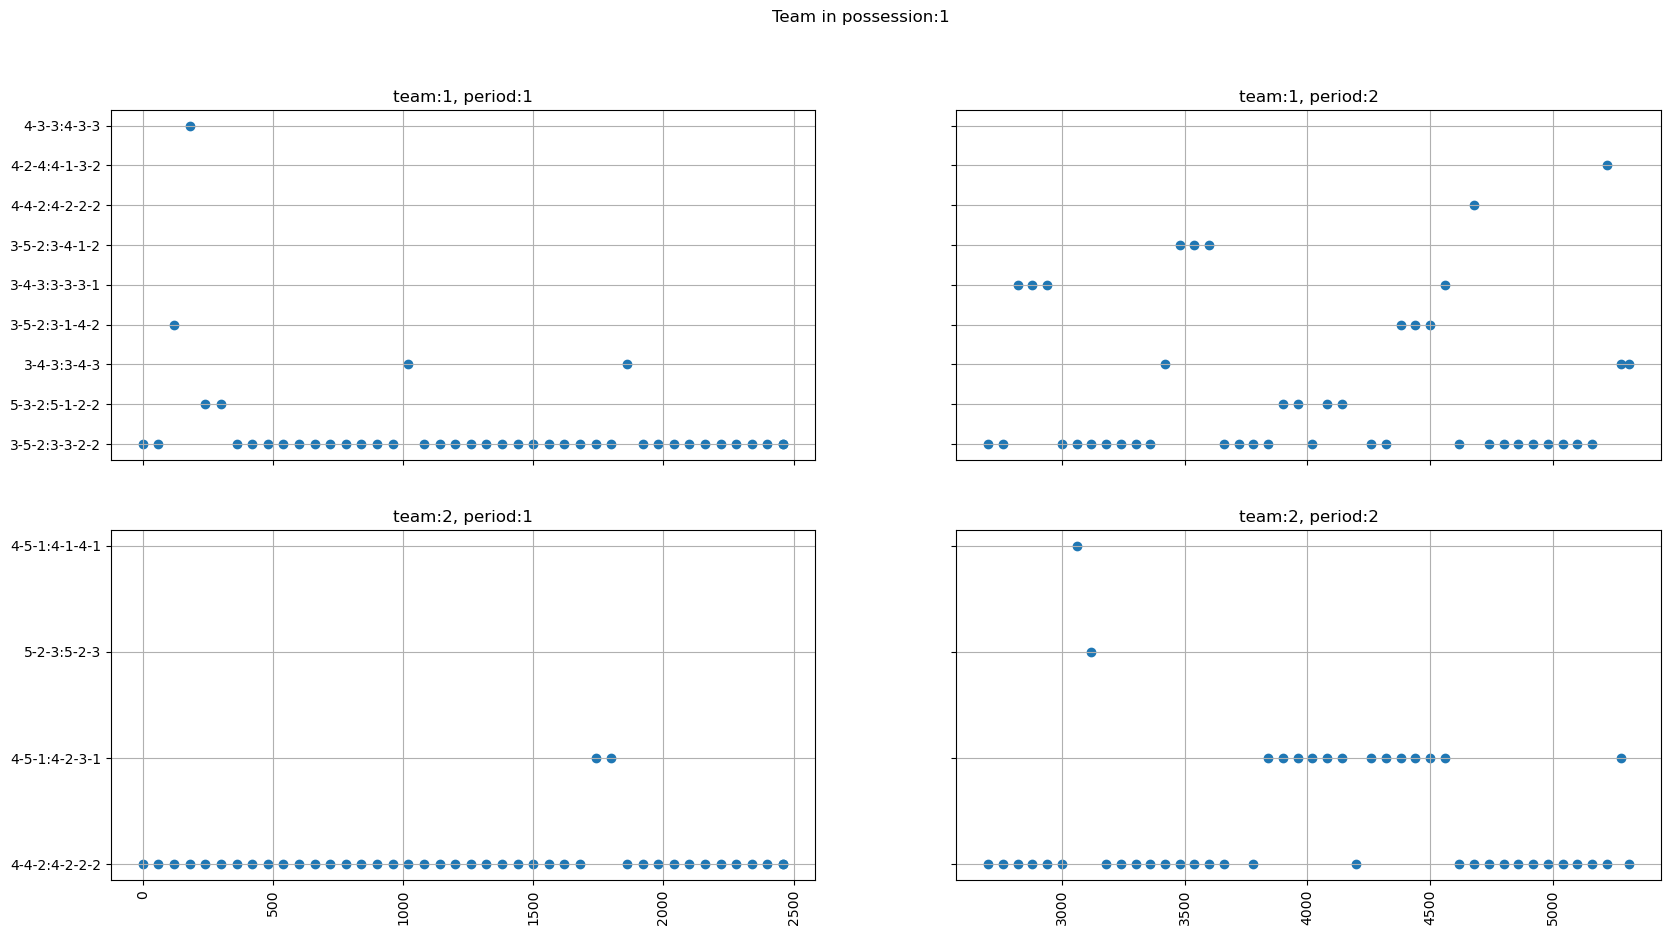

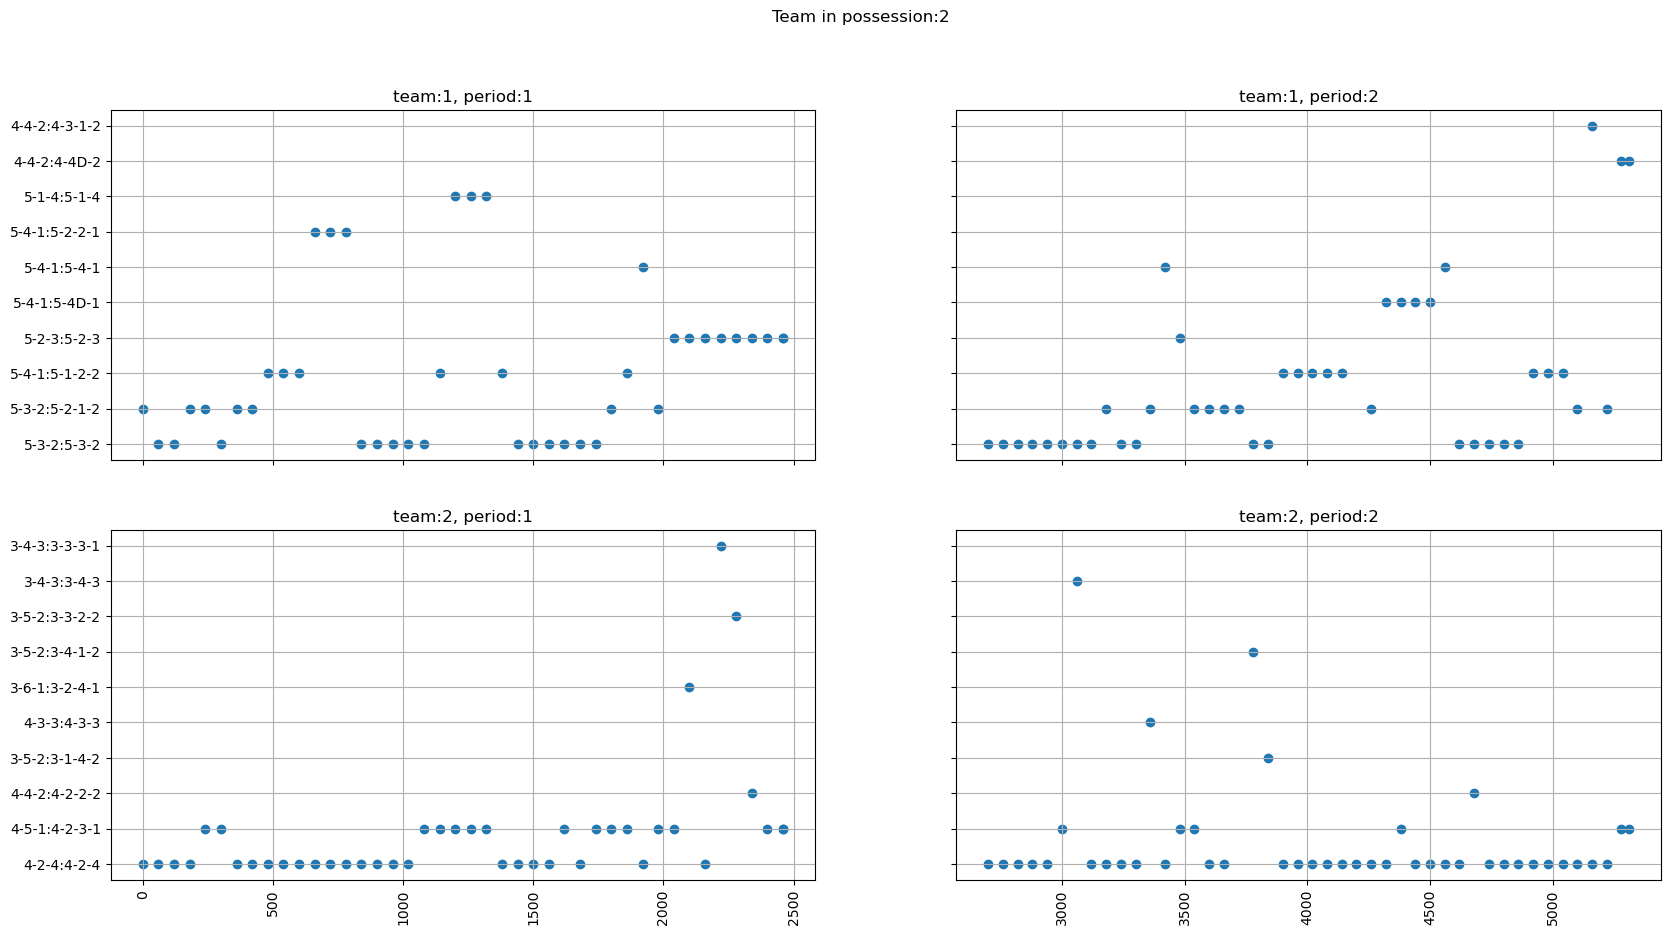

In [14]:
def plot_formation_timeline(
    df_shape_team,
    df_index,
    team_in_possession:int
):
    
    fig, axes = plt.subplots(
        2, 2, 
        sharex = 'col',
        sharey = 'row',
        figsize = (20,10)
    )

    for period in [1,2]:
        for team_id in [1,2]:
        
            ax = axes[team_id-1, period-1]

            ax.grid()
            
            plot_filter = ( df_shape_team['period'] == period ) & \
                ( df_shape_team['team_id'] == team_id )

            if team_id == team_in_possession:
                plot_filter = ( plot_filter ) & \
                ( df_shape_team['possession'] == 1 )
            elif team_id != team_in_possession:
                plot_filter = ( plot_filter ) & \
                ( df_shape_team['possession'] == 0 )
                
            df_shape_team_subset = df_shape_team[plot_filter]
            
            df_shape_team_subset = df_shape_team_subset.merge(
                df_index,
                on = ['team_id','possession','formation','team_shape']
            )

            ax.scatter(
                df_shape_team_subset['period_start'],
                df_shape_team_subset['index']
            )

            ax.set_title(f'team:{team_id}, period:{period}')

            if team_id == 2:
                ax.tick_params(axis='x', rotation=90)

            if period == 1:
                df_team_poss_formn_shape_index_subset = df_team_poss_formn_shape_index[
                    df_team_poss_formn_shape_index['team_id'] == team_id
                ]

                if team_id == team_in_possession:
                    y_ticks_filter = df_team_poss_formn_shape_index_subset['possession'] == 1
                elif team_id != team_in_possession:
                    y_ticks_filter = df_team_poss_formn_shape_index_subset['possession'] == 0

                df_team_poss_formn_shape_index_subset = df_team_poss_formn_shape_index_subset[y_ticks_filter]
                    
                ax.set_yticks(
                    df_team_poss_formn_shape_index_subset['index']
                )
                ax.set_yticklabels(
                    df_team_poss_formn_shape_index_subset['formation'] + ':' + \
                    df_team_poss_formn_shape_index_subset['team_shape']
                )

    fig.suptitle(f'Team in possession:{team_in_possession}')

    return fig, axes

fig, axes = plot_formation_timeline(
    df_shape_team = df_shape_team,
    df_index = df_team_poss_formn_shape_index,
    team_in_possession = 1
)

plt.show()
plt.close()


fig, axes = plot_formation_timeline(
    df_shape_team = df_shape_team,
    df_index = df_team_poss_formn_shape_index,
    team_in_possession = 2
)

plt.show()
plt.close()



We can visually see the more frequently occurring formations but we can also have a simple frequency based logic to extract this info.

In [15]:
frequent_occurrence_cutoff_pct = 0.1

df_frequent_shapes = df_team_poss_formn_shape_index[
    df_team_poss_formn_shape_index['window_pct'] > frequent_occurrence_cutoff_pct
]

df_frequent_shapes

,team_id,possession,formation,team_shape,windows,index,total_windows,window_pct
0,2,0,4-4-2,4-2-2-2,70,1,87,0.804598
1,1,1,3-5-2,3-3-2-2,62,1,87,0.712644
2,2,1,4-2-4,4-2-4,56,1,87,0.643678
3,1,0,5-3-2,5-3-2,31,1,87,0.356322
4,2,1,4-5-1,4-2-3-1,22,2,87,0.252874
5,1,0,5-3-2,5-2-1-2,16,2,87,0.183908
6,2,0,4-5-1,4-2-3-1,15,2,87,0.172414
7,1,0,5-4-1,5-1-2-2,14,3,87,0.160920
8,1,0,5-2-3,5-2-3,10,4,87,0.114943


The location of the roles on the pitch over all of the windows during the match for the more frequently occurring shapes look like as below -

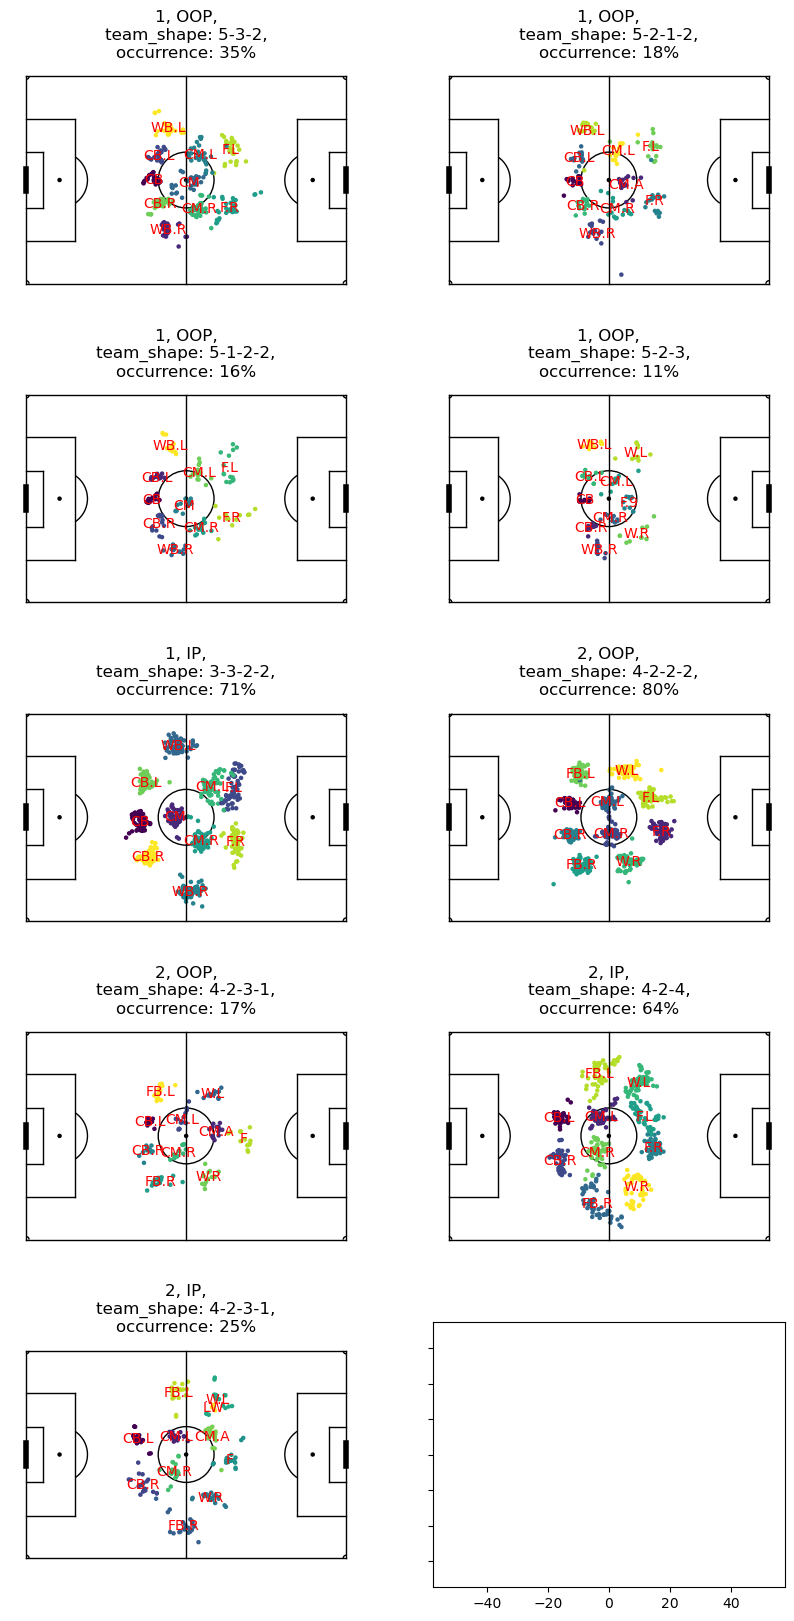

In [16]:
import math

def combine_some_roles(df_shape_player_subset, team_shape):

    if ( 'F.9' in df_shape_player_subset['role_description'].values ) & ( 'F' in df_shape_player_subset['role_description'].values ):

        df_shape_player_subset.loc[
            df_shape_player_subset['role_description'].isin(['F','F.9']),
            'role_description'
        ] = 'F/F9'

    if ( 'WB.R' in df_shape_player_subset['role_description'].values ) & ( 'FB.R' in df_shape_player_subset['role_description'].values ):

        df_shape_player_subset.loc[
            df_shape_player_subset['role_description'].isin(['WB.R','FB.R']),
            'role_description'
        ] = 'F/WB.R'

        df_shape_player_subset.loc[
            df_shape_player_subset['role_description'].isin(['WB.L','FB.L']),
            'role_description'
        ] = 'F/WB.L'

    if ( 'F.R' in df_shape_player_subset['role_description'].values ) & ( 'W.R' in df_shape_player_subset['role_description'].values ):

        if team_shape == '5-2-3':

            df_shape_player_subset.loc[
                ( df_shape_player_subset['role_description'].isin(['W.R','F.R']) ),
                'role_description'
            ] = 'F/W.R'

            df_shape_player_subset.loc[
                ( df_shape_player_subset['role_description'].isin(['W.L','F.L']) ),
                'role_description'
            ] = 'F/W.L'

    return df_shape_player_subset

def plot_shapes(
    df_shape_player,
    df_shape_team,
    df_shapes_to_plot,
    df_shape_index,
    by_template = False
):
        
    df_shapes_to_plot = df_shapes_to_plot.copy()
    
    df_shape_team_plot = df_shape_team.merge(
        df_shapes_to_plot[['team_id','possession','formation','team_shape']],
        on = ['team_id','possession','formation','team_shape']
    ).copy()
    
    df_shapes_to_plot = df_shape_team_plot[
        ['team_id','possession','formation','team_shape'] + \
        (['team_poss_formn_shape_index'] if False else [])
    ].drop_duplicates()
    
    df_shapes_to_plot = df_shapes_to_plot.merge(
        df_shape_index,
        on = list(df_shapes_to_plot.columns)
    )
    
    fig_rows = math.ceil(len(df_shapes_to_plot)/2)
    
    fig, axes = plt.subplots(
        fig_rows, 2, 
        sharex = True,
        sharey = True,
        figsize = (10,fig_rows*4)
    )

    df_shapes_to_plot['window_pct'] = -df_shapes_to_plot['window_pct']
    df_shapes_to_plot.sort_values(
        # ['team_id','possession','formation','team_shape'],
        ['team_id','possession','window_pct'],
        inplace = True
    )
    df_shapes_to_plot['window_pct'] = -df_shapes_to_plot['window_pct']

    for ax_index, ax in enumerate(axes.flat):

        if ax_index >= len(df_shapes_to_plot):
            continue
            
        frequent_shape = df_shapes_to_plot.iloc[ax_index]

        # TODO continue if frequent_shape.team_shape is NULL
        # You can visualise those but all the <10 outfield player
        # ones will be NULL and no role identifiers either so the 
        # visualisation will just be noisy 

        df_shape_team_subset = df_shape_team[
            ( df_shape_team['team_id'] == frequent_shape.team_id ) & \
            ( df_shape_team['possession'] == frequent_shape.possession ) & \
            ( df_shape_team['formation'] == frequent_shape.formation ) & \
            ( df_shape_team['team_shape'] == frequent_shape.team_shape )
        ].copy()

        if by_template:
            
            df_shape_team_subset = df_shape_team_subset[
                df_shape_team_subset['team_shape_template_id'] == frequent_shape.team_shape_template_id
            ]
            
        df_shape_player_subset = df_shape_player.merge(
            df_shape_team_subset[['team_id','possession','period','period_start']],
            on = ['team_id','possession','period','period_start']
        )
        
        if not by_template:

            df_shape_player_subset = combine_some_roles(
                df_shape_player_subset, 
                team_shape = frequent_shape.team_shape
            )

        role_descs = df_shape_player_subset['role_description'].unique()
        colors = np.linspace(0, 1, len(role_descs))
        colordict = dict(zip(role_descs, colors))  

        df_shape_player_subset["role_desc_color"] = df_shape_player_subset['role_description'].apply(lambda x: colordict[x])
    
        ax_title = f'{frequent_shape.team_id}, ' + \
            f'{"IP" if frequent_shape.possession else "OOP"},\n' + \
            f'team_shape: {frequent_shape.team_shape},\n'

        if by_template:
            
            ax_title = ax_title + \
                f'template: {frequent_shape.team_shape_template_id}\n'

        ax_title = ax_title + \
            f'occurrence: {str(int(100*frequent_shape.window_pct))}%'
            
        ax.set_title(ax_title)

        draw_pitch(ax)
        ax.axis("off")
        ax.set(aspect=1)

        ax.scatter(
            x = transform_x_from_opta_to_real_world(df_shape_player_subset['mean_x']),
            y = transform_y_from_opta_to_real_world(df_shape_player_subset['mean_y']),
            c = df_shape_player_subset["role_desc_color"],
            s = 5
        )

        # print(ax_index)
        # print(len(df_shape_player_subset['role_id'].unique()))

        df_role_text = df_shape_player_subset \
            .groupby(['role_description'], as_index = False) \
            .agg(mean_x = ('mean_x',np.mean), mean_y = ('mean_y',np.mean))

        for role in df_role_text.itertuples():
            ax.text(
                transform_x_from_opta_to_real_world(role.mean_x),
                transform_y_from_opta_to_real_world(role.mean_y),
                s = role.role_description,
                c = 'red',
                ha = 'center',
                va = 'center'
            )

plot_shapes(
    df_shape_player = df_shape_player,
    df_shape_team = df_shape_team,
    df_shapes_to_plot = df_frequent_shapes,
    df_shape_index = df_team_poss_formn_shape_index,
    by_template = False
)

plt.show()
plt.close()

For ease of analysis, we've limited our analysis to the shape level granularity in this tutorial but but there is actually another level of detail, which is a shape template. Each shape could have more than one template associated with it.

For instance, there is a further distinction in the OOP 5-2-3 shape with at least two templates -

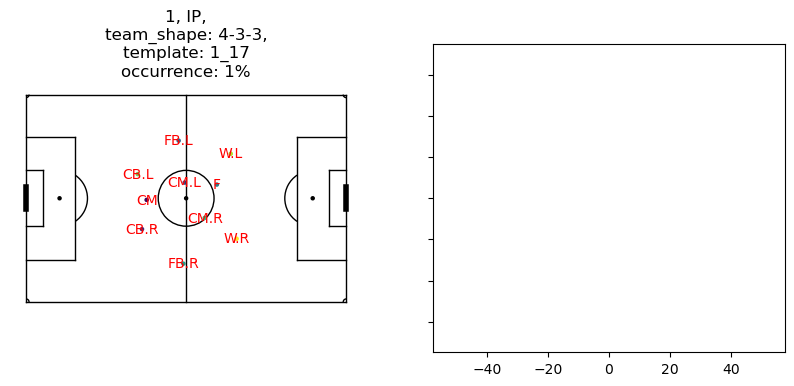

In [17]:
plot_shapes(
    df_shape_player = df_shape_player,
    df_shape_team = df_shape_team,
    df_shapes_to_plot = df_shape_team[
        ( df_shape_team['team_shape'] == '4-3-3' ) & \
        ( df_shape_team['team_id'] == 1 ) & \
        ( df_shape_team['possession'] == 1 )
    ],
    df_shape_index = df_team_poss_formn_shape_template_index,
    by_template = True
)

plt.show()
plt.close()

We'll continue to run our analysis at a shape level for the rest of this tutorial.

### Shape correlations

Let us see if there are any interesting correlations between any of the pairs of the four outputs of each team X team in possession over all the time windows we have run this model for.

We will do a simple analysis where we look for combinations that occur more frequently than what their overall occurrence would suggest.

In [18]:
def get_shape_combns(
    df_shape_team,
    incl_team_shape_template_ids = True
):

    if incl_team_shape_template_ids:
        team_shape_template_id = ['team_shape_template_id']
        team_shape_template_id_x = ['team_shape_template_id_x']
        team_shape_template_id_y = ['team_shape_template_id_y']
    else:
        team_shape_template_id = []
        team_shape_template_id_x = []
        team_shape_template_id_y = []

    df_shape_combns = pd.merge(
        df_shape_team[
            # df_shape_team['possession'] == 1
        # ][
            ['period','possession','period_start'] + \
            ['team_id','team_shape'] + team_shape_template_id
        ],
        df_shape_team[
            # df_shape_team['possession'] == 0
        # ][
            ['period','possession','period_start'] + \
            ['team_id','team_shape'] + team_shape_template_id
        ],
        on = ['period','period_start'],
        how = 'outer'
    )

    df_shape_combns = df_shape_combns.groupby(
        [
            'team_id_x',
            'possession_x',
            'team_shape_x'
        ] + \
        team_shape_template_id_x + \
        [
            'team_id_y',
            'possession_y',
            'team_shape_y'
        ] + \
        team_shape_template_id_y,
        as_index = False
    ).agg(
        windows = ('period_start',len)
    )

    # df_shape_combns.pivot_table(
    #     [
    #         'team_id_x',
    #         'team_id_x',
    #         'team_shape_template_id_x'
    #     ],
    #     ['team_shape_template_id_y'],
    #     ['period_start'],
    #     aggfunc = len
    # )

    df_shape_combns = df_shape_combns \
        .groupby(['team_id_x','team_id_y','possession_x','possession_y']) \
        .apply(
            lambda x:x.sort_values(by='windows',ascending=False)
        ) \
        .reset_index(drop=True)

    df_shape_combns['total_windows'] = df_shape_combns \
        .groupby(['team_id_x','team_id_y','possession_x','possession_y']) \
        ['windows'].transform(sum)

    df_shape_combns['total_windows_x'] = df_shape_combns \
        .groupby(['team_id_x','team_id_y','possession_x','possession_y','team_shape_x'] + team_shape_template_id_x + team_shape_template_id_y) \
        ['windows'].transform(sum)

    df_shape_combns['total_windows_y'] = df_shape_combns \
        .groupby(['team_id_x','team_id_y','possession_x','possession_y','team_shape_y'] + team_shape_template_id_x + team_shape_template_id_y) \
        ['windows'].transform(sum)

    df_shape_combns['window_pct_of_total'] = df_shape_combns['windows'] / df_shape_combns['total_windows']
    df_shape_combns['window_pct_of_x'] = df_shape_combns['windows'] / df_shape_combns['total_windows_x']
    df_shape_combns['x_pct_of_total'] = df_shape_combns['total_windows_x'] / df_shape_combns['total_windows']
    df_shape_combns['window_pct_of_y'] = df_shape_combns['windows'] / df_shape_combns['total_windows_y']
    df_shape_combns['y_pct_of_total'] = df_shape_combns['total_windows_y'] / df_shape_combns['total_windows']


    # done at the end so that all the window counts are correct
    df_shape_combns = df_shape_combns[
        (
            ( df_shape_combns['team_id_x'] != df_shape_combns['team_id_y'] )
            # ( df_shape_combns['possession_x'] <= df_shape_combns['possession_y'] )
        ) | \
        (
            ( df_shape_combns['team_id_x'] == df_shape_combns['team_id_y'] ) & \
            # ( df_shape_combns['possession_x'] < df_shape_combns['possession_y'] ) & \
            ( df_shape_combns['possession_x'] != df_shape_combns['possession_y'] )
        )
    ]

    return df_shape_combns


window_pct_of_total_cutoff = 0.2
conditional_pct_of_total_cutoff = 0.1
delta_for_interest = 0.1


print('Shape level combinations')

df_shape_combns = get_shape_combns(
    df_shape_team,
    incl_team_shape_template_ids = False
)

# high overall probability
print('High occurrence: p(x and y) >> p(x)*p(y)')
display(df_shape_combns[
    ( df_shape_combns['window_pct_of_total'] > window_pct_of_total_cutoff ) & \
    ( df_shape_combns['window_pct_of_total'] > ( ( df_shape_combns['x_pct_of_total'] * df_shape_combns['y_pct_of_total'] ) + delta_for_interest ) )
])

print('High occurrence conditional on x: p(y|x) >> p(y)')
# conditional probability higher than overall probability
display(df_shape_combns[(
    ( df_shape_combns['x_pct_of_total'] > 0.2 ) & \
    ( df_shape_combns['window_pct_of_x'] - df_shape_combns['y_pct_of_total'] > delta_for_interest ) & \
    ( df_shape_combns['window_pct_of_x'] > conditional_pct_of_total_cutoff )
)])


Shape level combinations
High occurrence: p(x and y) >> p(x)*p(y)


,team_id_x,possession_x,team_shape_x,team_id_y,possession_y,team_shape_y,windows,total_windows,total_windows_x,total_windows_y,window_pct_of_total,window_pct_of_x,x_pct_of_total,window_pct_of_y,y_pct_of_total


High occurrence conditional on x: p(y|x) >> p(y)


,team_id_x,possession_x,team_shape_x,team_id_y,possession_y,team_shape_y,windows,total_windows,total_windows_x,total_windows_y,window_pct_of_total,window_pct_of_x,x_pct_of_total,window_pct_of_y,y_pct_of_total
184,2,1,4-2-3-1,1,0,5-2-3,5,86,22,10,0.058140,0.227273,0.255814,0.5,0.116279
190,2,1,4-2-3-1,1,0,5-1-4,3,86,22,3,0.034884,0.136364,0.255814,1.0,0.034884
